## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = 10 #c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
sys

'Combined'

In [4]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 2,
                            index1 = 6,
                            index2 = 0.6, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        #setup.set_piecewise_pl_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True
        else:
            for d in [dataset_asimov, dataset_asimov_N]:
                delta = 0.01 
                dataset_asimov.models.parameters['lon_0'].min = dataset_asimov.models.parameters['lon_0'].value - delta
                dataset_asimov.models.parameters['lon_0'].max = dataset_asimov.models.parameters['lon_0'].value + delta 
                dataset_asimov.models.parameters['lat_0'].min = dataset_asimov.models.parameters['lat_0'].value - delta
                dataset_asimov.models.parameters['lat_0'].max = dataset_asimov.models.parameters['lat_0'].value + delta
                
                
        dataset_asimov_N.models.parameters['_norm'].frozen = False
        #dataset_asimov_N.models.parameters['tilt'].frozen = False
        

    return dataset_asimov_N, dataset_asimov, setup

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
0 2.154434690031884
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 166
	total stat : 10219.24

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.09             
    amplitude                     :   3.85e-11   +/- 2.6e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.04 1 / TeV  

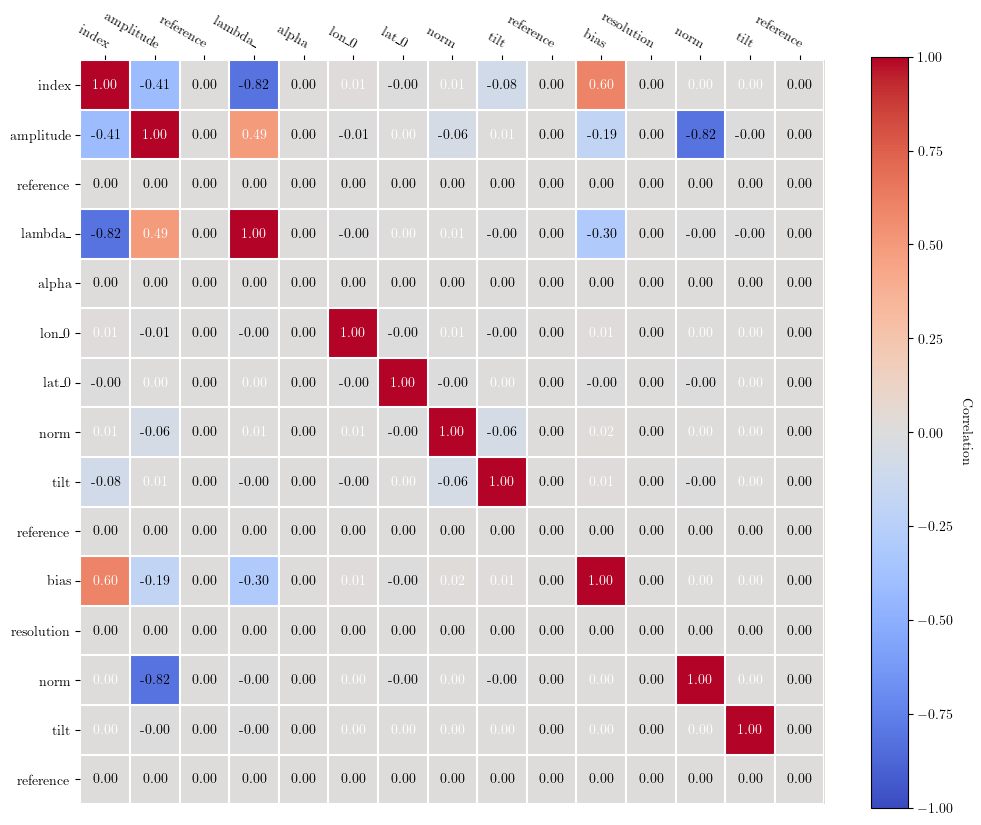

In [5]:
%%time
e_reco_n = 3000
if sys == "Eff_area" or sys == "BKG":
    e_reco_n = 10
    
livetimes = [c['livetime']]#[100.0]
#livetimes = [100.0]
fitting_anyting = 1
if fitting_anyting :
    for i,l in enumerate(livetimes):
        datasets_  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)
        datasets_i=  datasets_.cutout(datasets_._geom.center_skydir, 
                         (1,1) *u.deg, name = datasets_.name)
        datasets_i.models = datasets_.models
        dataset_asimov_N, dataset_asimov, setup = set_up(datasets_i)
        dataset_asimov_N.e_reco_n =e_reco_n

        fitting = 1
        if fitting:
            
            print(i, livetimes[i])
            fit_cor = Fit(store_trace=0)
            minuit_opts = {"tol": 0.1, "strategy": 2}
            fit_cor.backend = "minuit"
            fit_cor.optimize_opts = minuit_opts
            result_cor = fit_cor.run(dataset_asimov)
            print(result_cor)
            print(dataset_asimov.models)
            print("saving")
            path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
            dataset_asimov.models.write(path,overwrite=True)

        else:
            print(i)

        fitting_N = 1

        if fitting_N:
            if i == 0:
            
                print(i)
                fit_cor = Fit(store_trace=0)
                minuit_opts = {"tol": 0.1, "strategy": 2}
                fit_cor.backend = "minuit"
                fit_cor.optimize_opts = minuit_opts
                result_cor = fit_cor.run(dataset_asimov_N)
                print(result_cor)
                print(dataset_asimov_N.models)
                print("saving")
                path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}_{e_reco_n}.yml'
                dataset_asimov_N.models.write(path,overwrite=True)
                cov = fit_cor.covariance(dataset_asimov_N, result_cor)  
                dataset_asimov_N.models.covariance.data  = cov.matrix                
                ax = dataset_asimov_N.models.covariance.plot_correlation()
                plt.savefig(f'../{folder}/plots/0_corr_nui_livetime_{livetimes[i]}_{e_reco_n}.pdf')
        else:
            print(livetimes[i])


else:
    datasets_i =  Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)

In [6]:
result_cor.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.022e+04                  │              Nfcn = 343              │
│ EDM = 4.42e-05 (Goal: 0.0002)    │          time = 1013.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.11    │            │            │         │         │       │
│ 1 │ par_001_amplitude │    3.8    │    0.5    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │    1.0    │    0.4    │            │            │         │         │       │
│ 3 │ par_003_lon_0     │ 3.296800  │ 0.000023  │            │            │ 3.2868  │ 3.3068  │       │
│ 4 │ par_004_lat_0     │ -3.02217  │  0.00020  │            │            │-3.12217 │-2.92217 │       │
│ 5 │ par_005_norm      │   1.00    │   0.04    │            │            │         │         │       │
│ 6 │ par_006_tilt      │   -0.00   │   0.05    │            │            │         │         │       │
│ 7 │ par_007_bias      │   -0.00   │   0.04    │            │            │         │         │       │
│ 8 │ par_008_norm      │   -0.0    │    0.1    │            │            │         │         │       │
│ 9 │ par_009_tilt      │   -0.00   │   0.02    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_     par_003_lon_0     par_004_lat_0      par_005_norm      par_006_tilt      par_007_bias      par_008_norm      par_009_tilt │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │             0.013            -0.022            -0.038           21.8e-9          -0.07e-6            0.0000           -0.0004            0.0025             0.000                 0 │
│ par_001_amplitude │            -0.022             0.223              0.10          -56.7e-9           0.18e-6           -0.0010            0.0001           -0.0034            -0.039                -0 │
│   par_002_lambda_ │            -0.038              0.10              0.17          -35.7e-9           0.13e-6            0.0001           -0.0000           -0.0046             -0.00                -0 │
│     par_003_lon_0 │           21.8e-9          -56.7e-9          -35.7e-9          5.21e-10                -0            5.1e-9           -0.9e-9           11.1e-9                 0                 0 │
│     par_004_lat_0 │          -0.07e-6           0.18e-6           0.13e-6                -0           3.9e-08          -0.02e-6                 0          -0.04e-6                -0                 0 │


<Figure size 640x480 with 0 Axes>

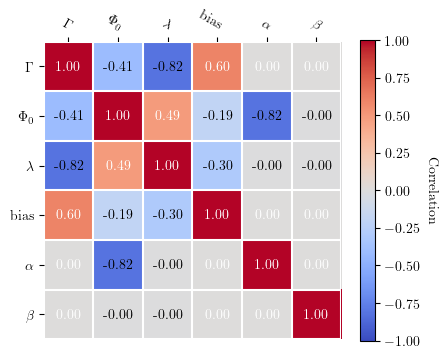

In [32]:
fig = plt.figure()
dataset_asimov_N.background_model.parameters.freeze_all()
dataset_asimov_N.models.parameters['lon_0'].frozen = True
dataset_asimov_N.models.parameters['lat_0'].frozen = True

print(parameters)
parameters = dataset_asimov_N.models.parameters.free_parameters
names = parameters.names
names[0] = '$\Gamma$'
names[1] = '$\Phi_0$'
names[2] = '$\lambda$'
names[4] = '$\\alpha$'
names[5] = '$\\beta$'


ax = dataset_asimov_N.models.covariance.get_subcovariance(parameters).plot_correlation(names=names)

plt.savefig(f'../{folder}/plots/0_corr_nui_livetime_{livetimes[i]}_{e_reco_n}_compact.pdf')


shift 1.0


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

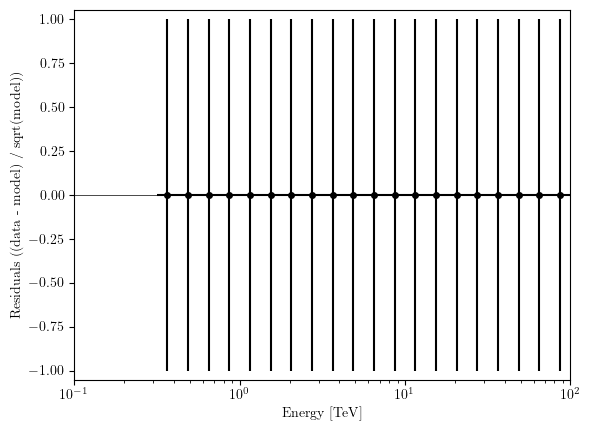

In [11]:
dataset_asimov.plot_residuals_spectral(method = 'diff/sqrt(model)')